# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 8184994.29it/s] 


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 267409.48it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2546041.48it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2272519.24it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



# Simple Autoencoder

We will define a simple MLP Autoencoder

In [5]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x            

In [6]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [7]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 0.048668
epoch : 1/10, Test loss = 0.024119


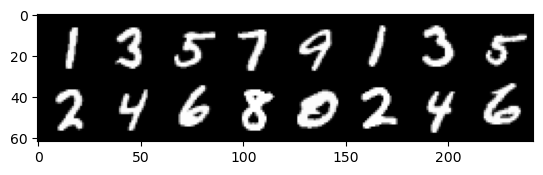

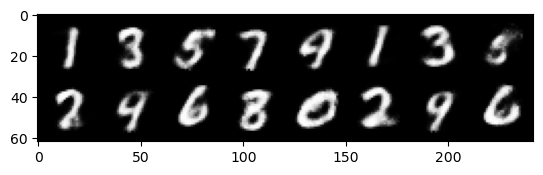

epoch : 2/10, Train loss = 0.019546
epoch : 2/10, Test loss = 0.015595


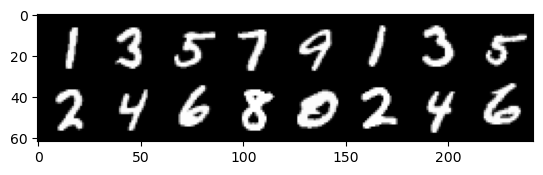

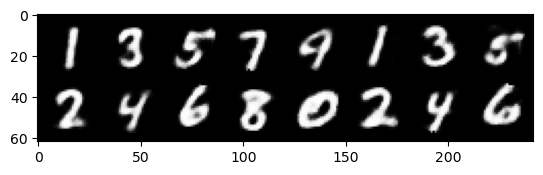

epoch : 3/10, Train loss = 0.014536
epoch : 3/10, Test loss = 0.012641


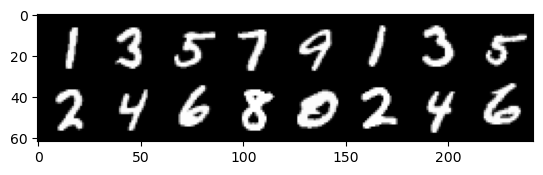

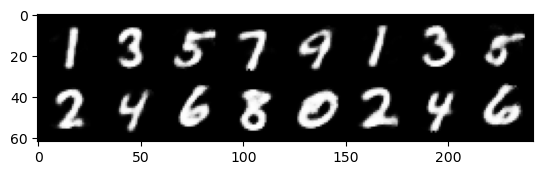

epoch : 4/10, Train loss = 0.012032
epoch : 4/10, Test loss = 0.010733


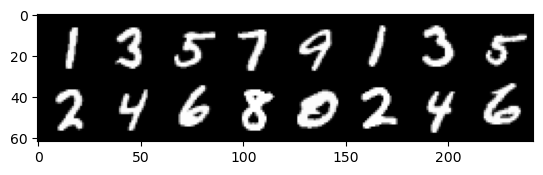

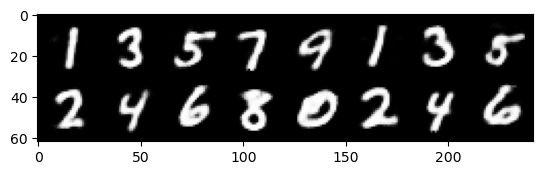

epoch : 5/10, Train loss = 0.010454
epoch : 5/10, Test loss = 0.009514


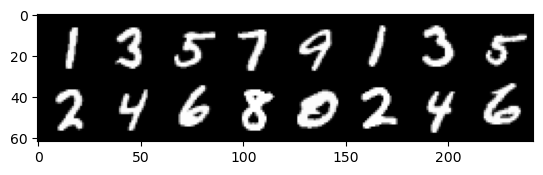

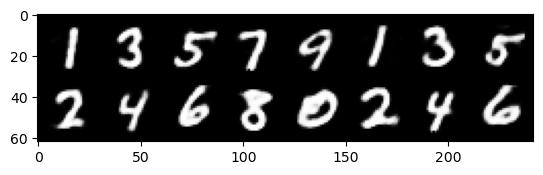

epoch : 6/10, Train loss = 0.009326
epoch : 6/10, Test loss = 0.008513


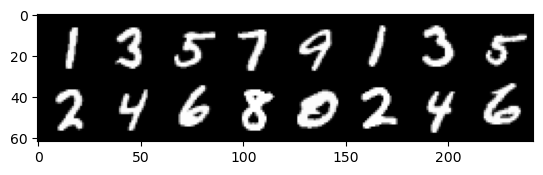

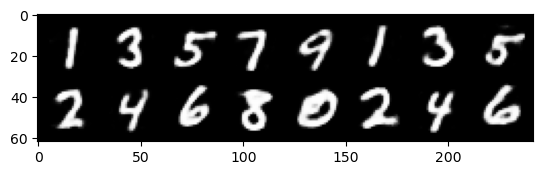

epoch : 7/10, Train loss = 0.008447
epoch : 7/10, Test loss = 0.007865


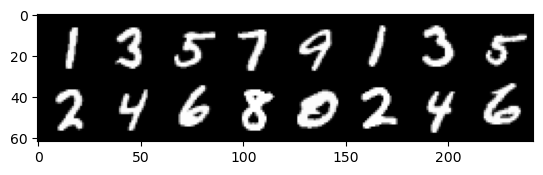

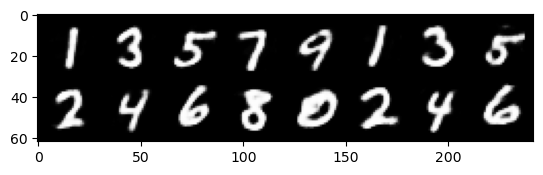

epoch : 8/10, Train loss = 0.007761
epoch : 8/10, Test loss = 0.007197


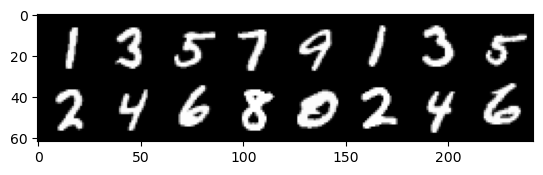

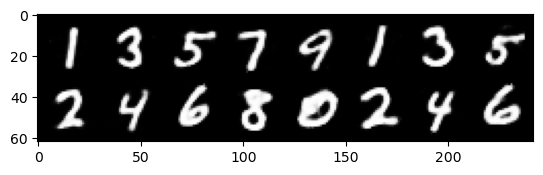

epoch : 9/10, Train loss = 0.007231
epoch : 9/10, Test loss = 0.006816


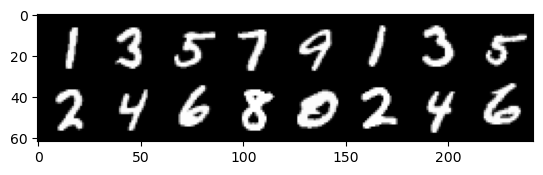

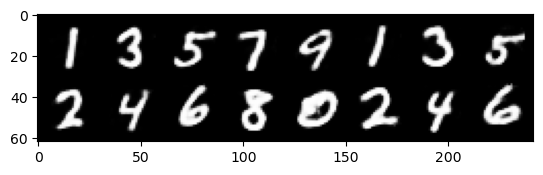

epoch : 10/10, Train loss = 0.006781
epoch : 10/10, Test loss = 0.006393


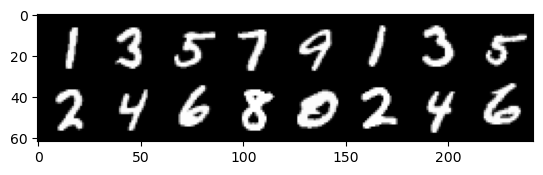

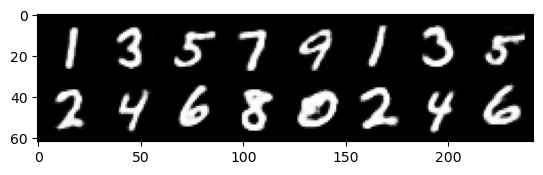

In [8]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True) 

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [9]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            
            # THIS PART IS MISSING...
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<span style="color:blue">

**Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

In [10]:
# SOLUTION

class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential( # Your code here
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# SOLUTION (cont)

model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.107580
epoch : 1/10, Test loss = 0.079657


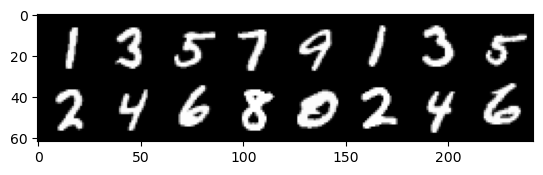

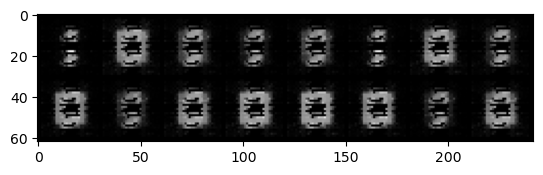

epoch : 2/10, Train loss = 0.058697
epoch : 2/10, Test loss = 0.047532


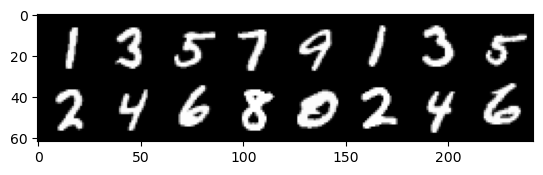

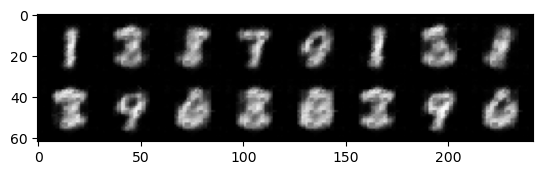

epoch : 3/10, Train loss = 0.044548
epoch : 3/10, Test loss = 0.041180


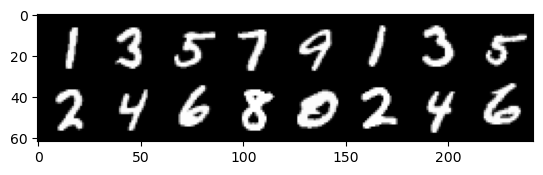

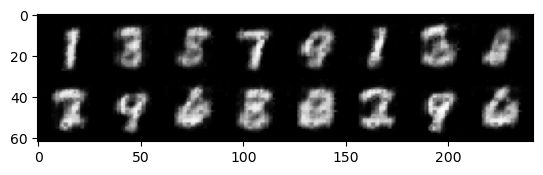

epoch : 4/10, Train loss = 0.039809
epoch : 4/10, Test loss = 0.037640


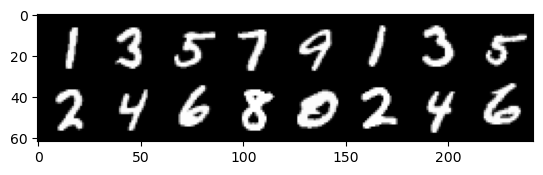

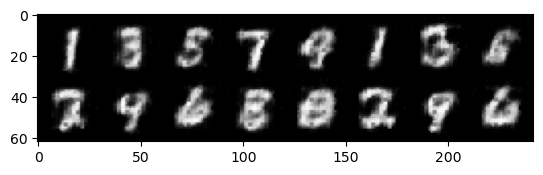

epoch : 5/10, Train loss = 0.036910
epoch : 5/10, Test loss = 0.035274


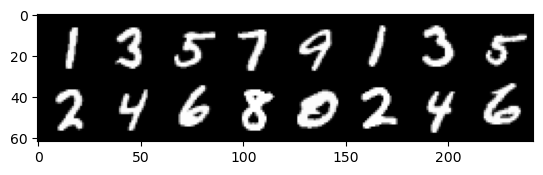

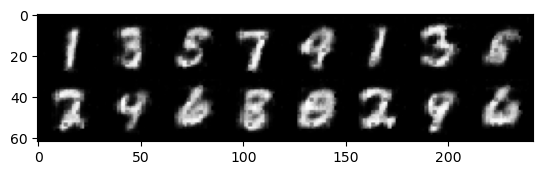

epoch : 6/10, Train loss = 0.035027
epoch : 6/10, Test loss = 0.033794


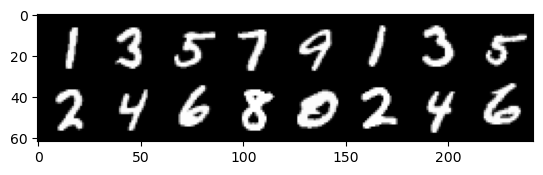

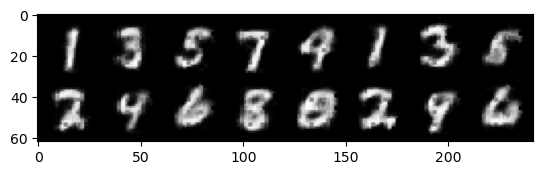

epoch : 7/10, Train loss = 0.033689
epoch : 7/10, Test loss = 0.032585


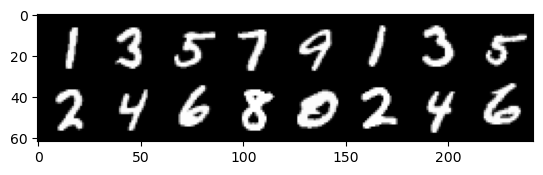

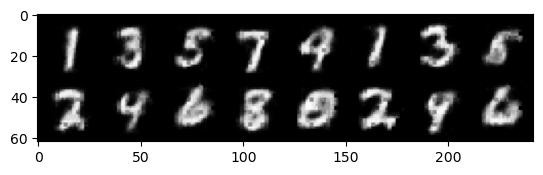

epoch : 8/10, Train loss = 0.032662
epoch : 8/10, Test loss = 0.031596


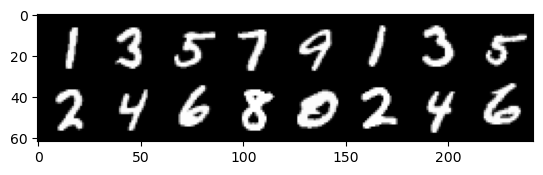

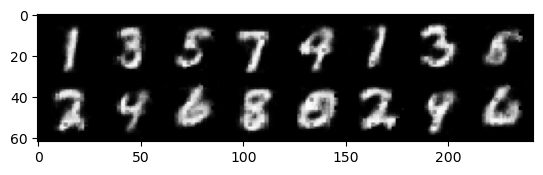

epoch : 9/10, Train loss = 0.031691
epoch : 9/10, Test loss = 0.030607


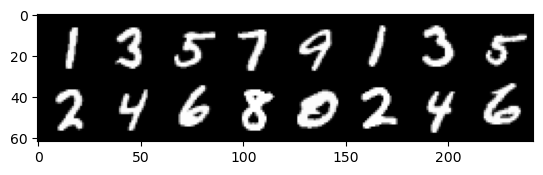

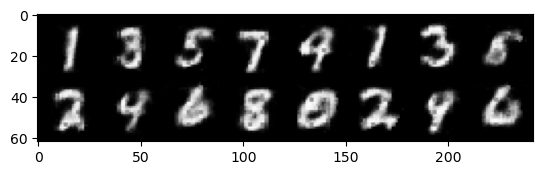

epoch : 10/10, Train loss = 0.030859
epoch : 10/10, Test loss = 0.029896


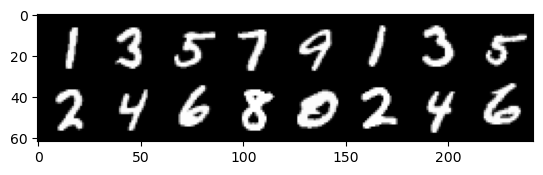

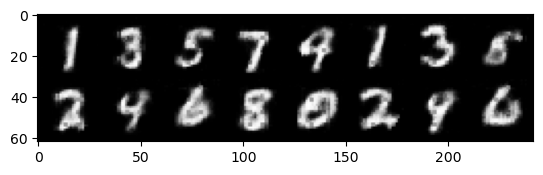

In [12]:
# SOLUTION (cont)

epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader, criterion) 

<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [13]:
# SYMMETRIC SOLUTION

class ConvAE2(nn.Module):
    def __init__(self):
        super(ConvAE2, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, stride=3, padding=1)  # b, 16, 10, 10
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # b, 16, 5, 5
        self.conv2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)  # b, 8, 3, 3
        self.pool2 = nn.MaxPool2d(2, stride=1, return_indices=True) # b, 8, 2, 2

        #Decoder
        self.unpool1 = nn.MaxUnpool2d(2, stride = 1)
        self.unconv1 = nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1)
        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)        
        self.unconv2 = nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1)
        
    def encode(self, x):
        x = torch.relu(self.conv1(x))
        x, self.indices1 = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x, self.indices2 = self.pool2(x)
        return x
    
    def decode(self, x):
        x = self.unpool1(x, self.indices2)
        x = torch.relu(self.unconv1(x))
        x = self.unpool2(x, self.indices1)
        x = torch.sigmoid(self.unconv2(x))
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [14]:
# SYMMETRIC SOLUTION (cont)

model = ConvAE2().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.172446
epoch : 1/10, Test loss = 0.129609


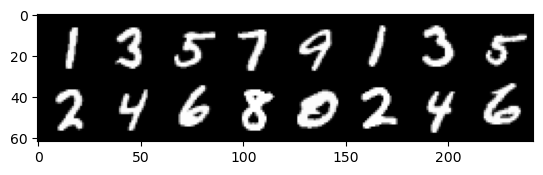

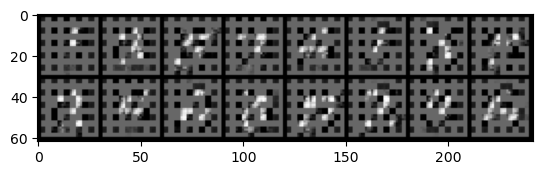

epoch : 2/10, Train loss = 0.106399
epoch : 2/10, Test loss = 0.089213


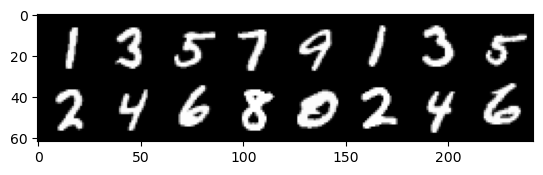

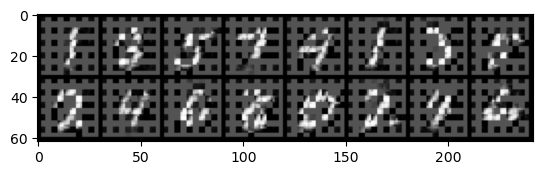

epoch : 3/10, Train loss = 0.076733
epoch : 3/10, Test loss = 0.066232


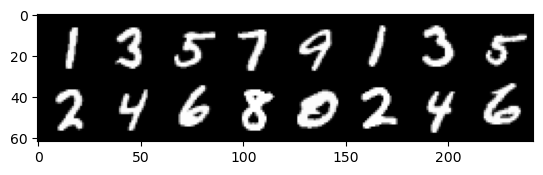

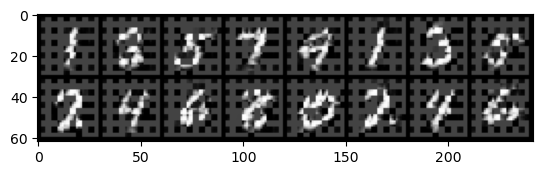

epoch : 4/10, Train loss = 0.058883
epoch : 4/10, Test loss = 0.052706


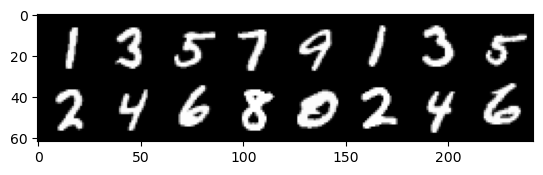

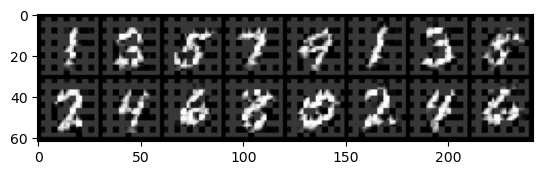

epoch : 5/10, Train loss = 0.048028
epoch : 5/10, Test loss = 0.044234


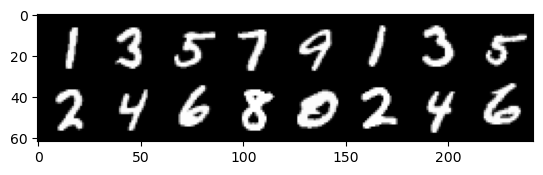

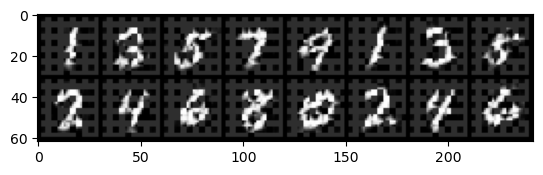

epoch : 6/10, Train loss = 0.041224
epoch : 6/10, Test loss = 0.038709


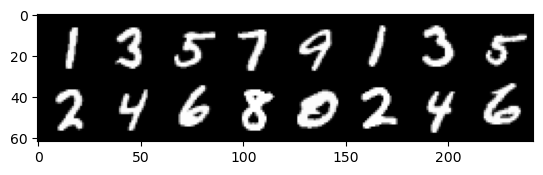

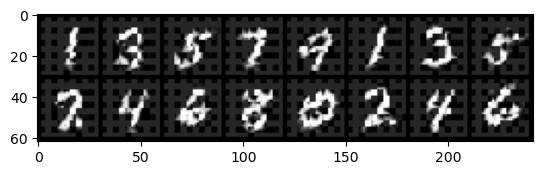

epoch : 7/10, Train loss = 0.036052
epoch : 7/10, Test loss = 0.034167


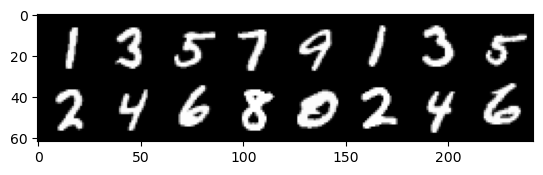

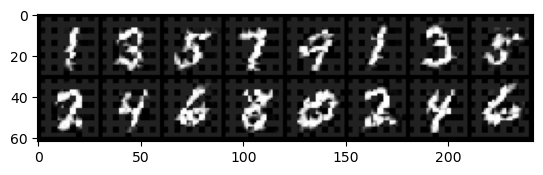

epoch : 8/10, Train loss = 0.032237
epoch : 8/10, Test loss = 0.030960


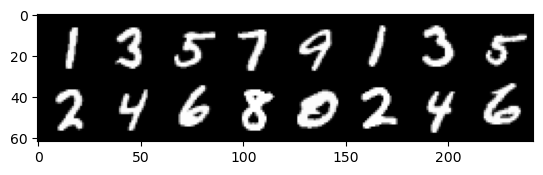

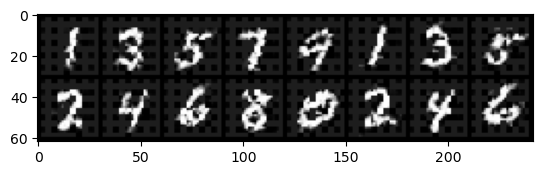

epoch : 9/10, Train loss = 0.029414
epoch : 9/10, Test loss = 0.028151


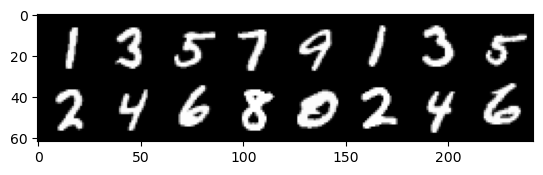

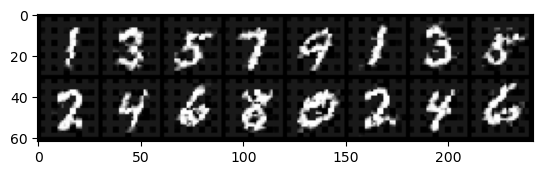

epoch : 10/10, Train loss = 0.026876
epoch : 10/10, Test loss = 0.026162


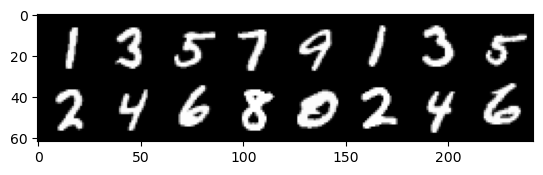

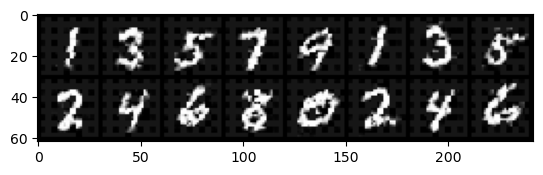

In [15]:
# SYMMETRIC SOLUTION (cont)

epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader, criterion) 

# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):        
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assume a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by summing.*

In [67]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generated images
    x:       input images
    mu:      latent mean
    logvar:  latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # KLD loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # Below is the same expression but using logvar instead of sigma. Remember that logvar = log(sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [68]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [69]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()    
    
    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    print(batch_features.shape)
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 5644.574115
epoch : 1/10, Test loss = 1013.929222
torch.Size([16, 784])


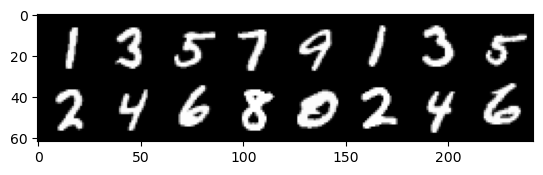

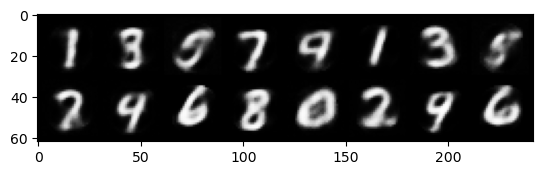

epoch : 2/10, Train loss = 3707.725023
epoch : 2/10, Test loss = 858.573049
torch.Size([16, 784])


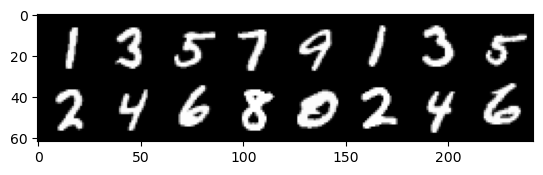

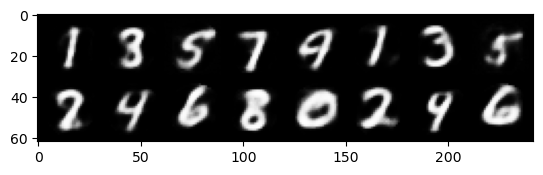

epoch : 3/10, Train loss = 3367.284084
epoch : 3/10, Test loss = 808.377924
torch.Size([16, 784])


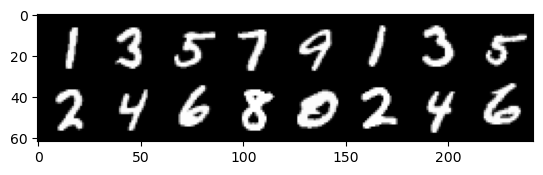

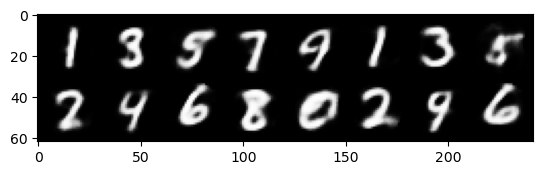

epoch : 4/10, Train loss = 3222.445263
epoch : 4/10, Test loss = 783.590215
torch.Size([16, 784])


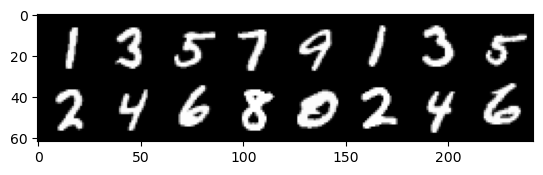

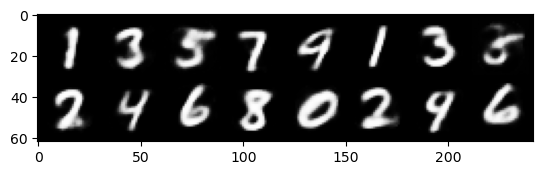

epoch : 5/10, Train loss = 3133.436642
epoch : 5/10, Test loss = 767.102791
torch.Size([16, 784])


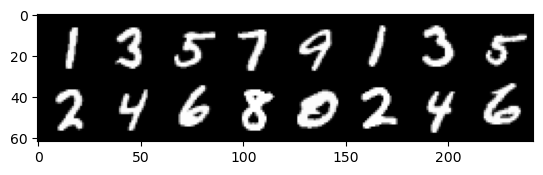

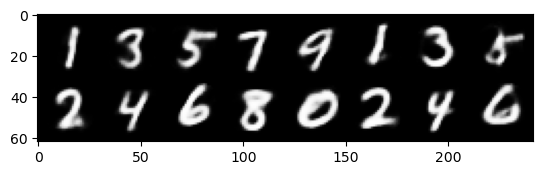

epoch : 6/10, Train loss = 3075.354926
epoch : 6/10, Test loss = 760.107593
torch.Size([16, 784])


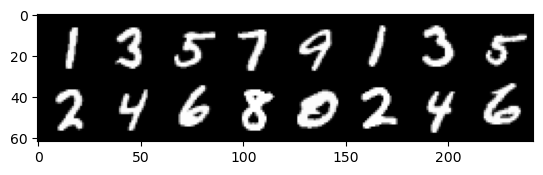

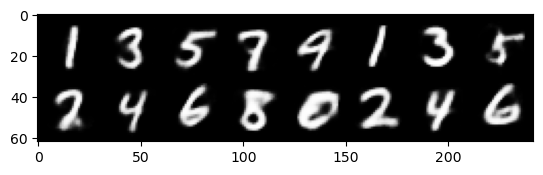

epoch : 7/10, Train loss = 3034.029729
epoch : 7/10, Test loss = 750.722672
torch.Size([16, 784])


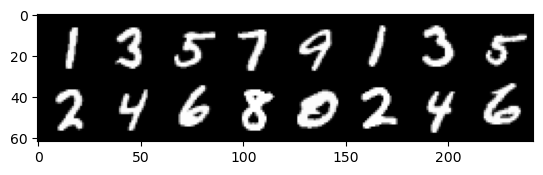

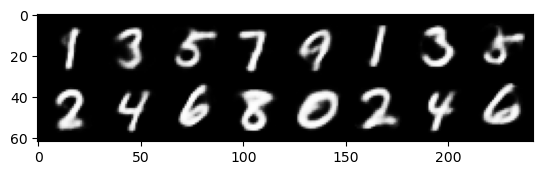

epoch : 8/10, Train loss = 3004.394637
epoch : 8/10, Test loss = 744.050258
torch.Size([16, 784])


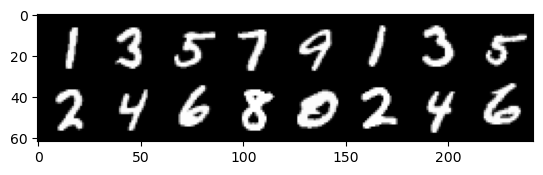

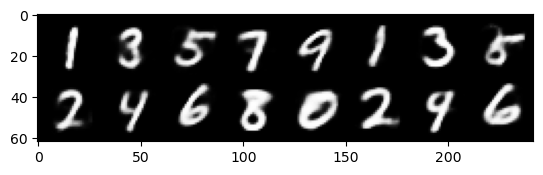

epoch : 9/10, Train loss = 2979.027748
epoch : 9/10, Test loss = 735.760571
torch.Size([16, 784])


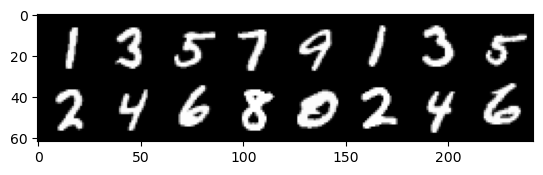

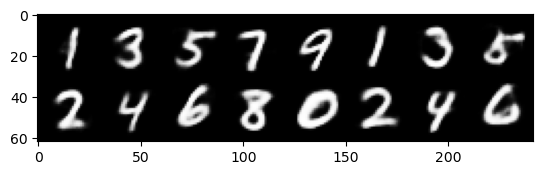

epoch : 10/10, Train loss = 2957.993865
epoch : 10/10, Test loss = 735.086101
torch.Size([16, 784])


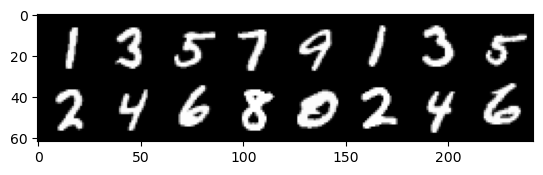

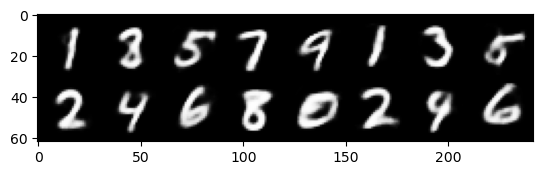

In [70]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion) 

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [71]:
model.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):   
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits
    
    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])
    
        inter_image = inter_image.view(1, 28, 28)
        
        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show() 

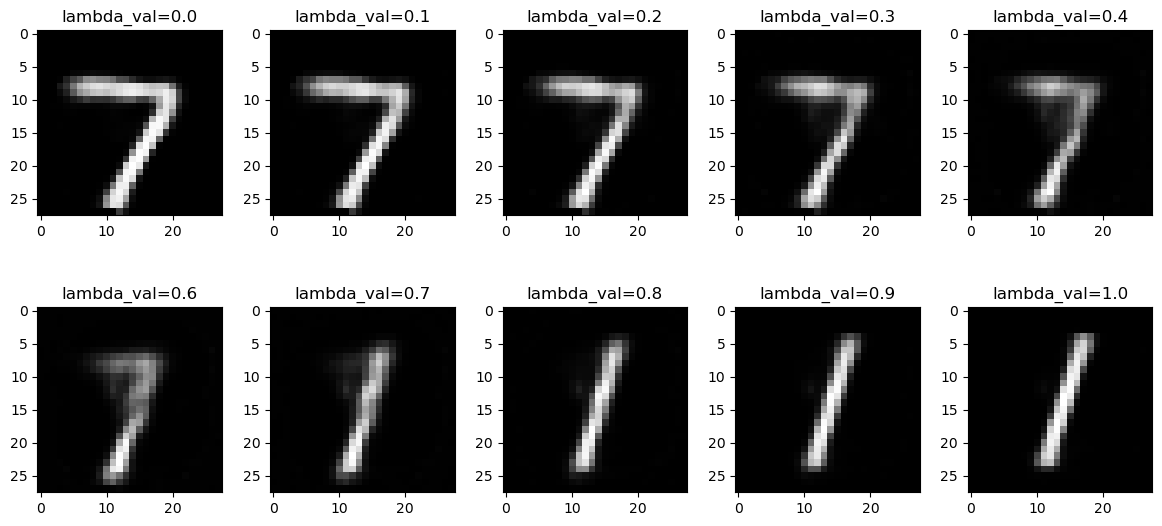

In [72]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

**Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

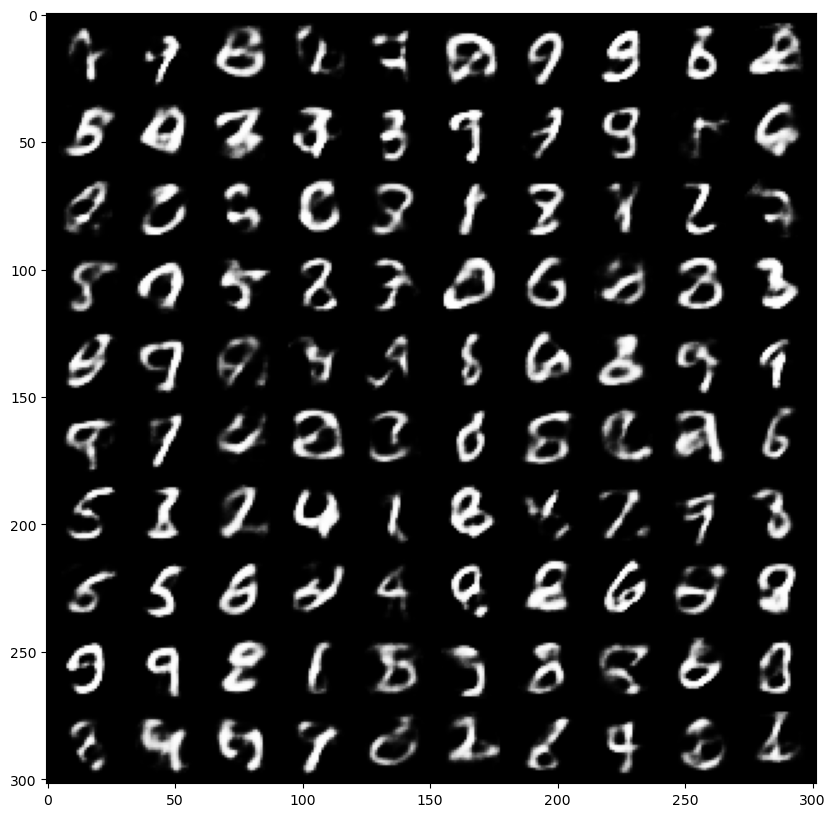

In [73]:
# SOLUTION

model.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(100, 20, device=device)

    # reconstruct images from the latent vectors
    img_recon = model.decode(latent)
    img_recon = img_recon.cpu()
    img_recon = img_recon.view(-1, 1, 28, 28)    
    img_recon = img_recon.transpose(2, 3)

    fig, ax = plt.subplots(figsize=(10, 10))    
    show_image(torchvision.utils.make_grid(img_recon.data, nrow = 10))
    plt.show()

<span style="color:blue">

**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

NameError: name 'image_recon' is not defined

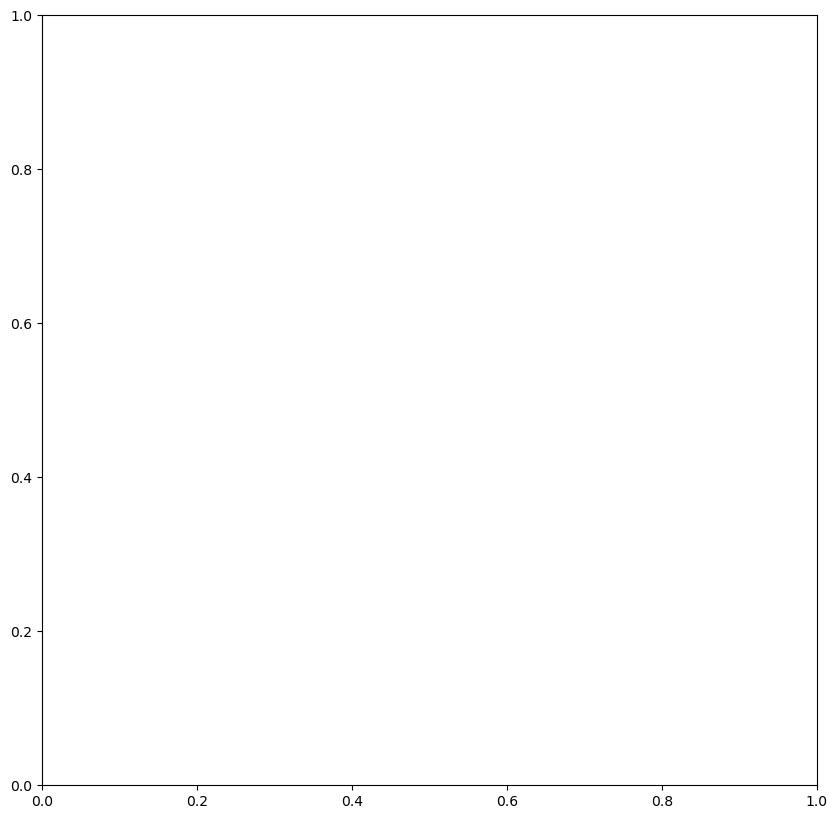

In [74]:
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    # Your code here
   
   
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.view(-1, 1, 28, 28).transpose(2,3), 20, 5))
    plt.show()

In [75]:
# SOLUTION

# Redefine the model
class VAE2(nn.Module):
    def __init__(self):
        super(VAE2, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)

        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [76]:
# SOLUTION (cont)

# Train
model2 = VAE2().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

epochs=10
for epoch in range(epochs):
    train_vae(model2, train_loader, optimizer, loss_function)

epoch : 1/10, Train loss = 6274.534787
epoch : 2/10, Train loss = 5413.852187
epoch : 3/10, Train loss = 5260.316377
epoch : 4/10, Train loss = 5171.014309
epoch : 5/10, Train loss = 5108.126236
epoch : 6/10, Train loss = 5060.820624
epoch : 7/10, Train loss = 5022.073164
epoch : 8/10, Train loss = 4993.465819
epoch : 9/10, Train loss = 4967.683646
epoch : 10/10, Train loss = 4943.516104


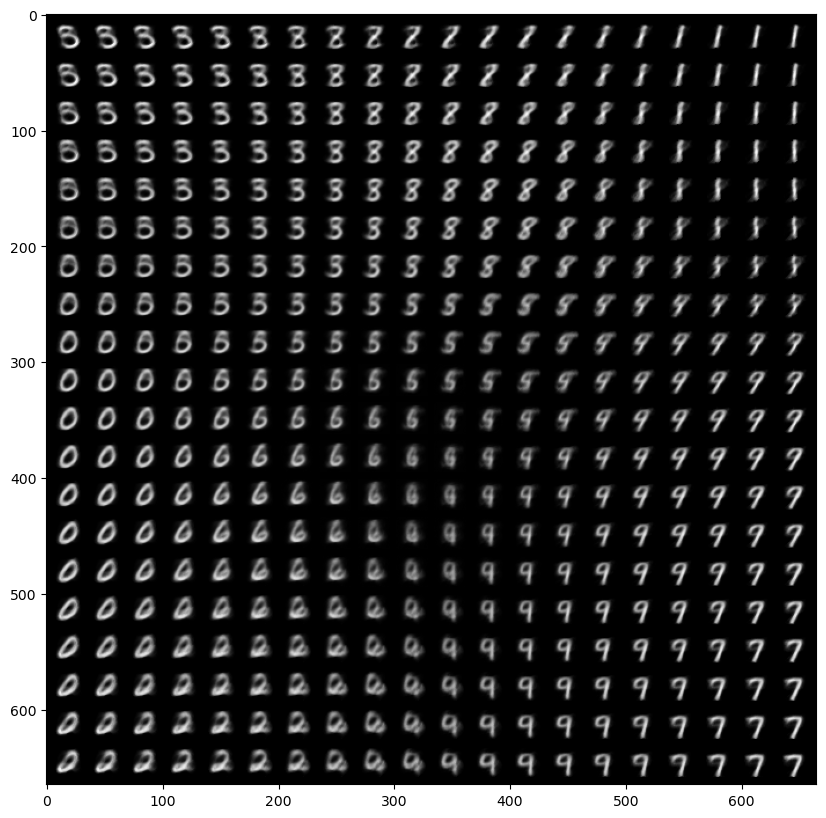

In [77]:
# SOLUTION (cont)

with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    # Your code here
    latents = latents.to(device)
    image_recon = model2.decode(latents)
    image_recon = image_recon.cpu()
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.view(-1, 1, 28, 28).transpose(2, 3), 20, 5))
    plt.show()

<span style="color:blue">

**Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [78]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

epoch : 1/10, Train loss = 0.037382
epoch : 1/10, Test loss = 0.022007


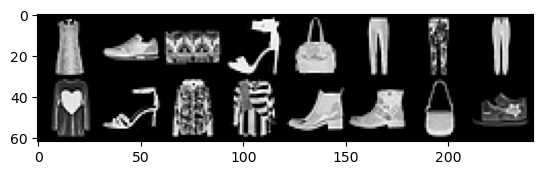

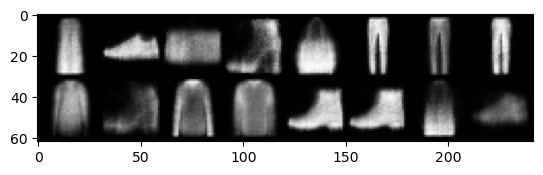

epoch : 2/10, Train loss = 0.019648
epoch : 2/10, Test loss = 0.017834


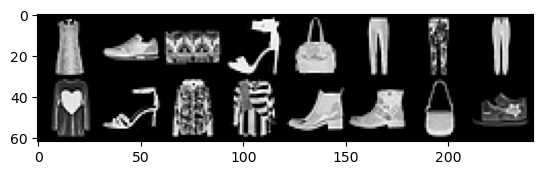

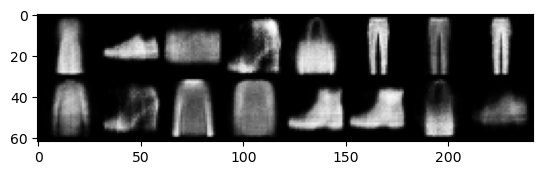

epoch : 3/10, Train loss = 0.016492
epoch : 3/10, Test loss = 0.015526


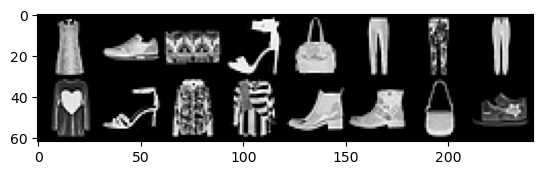

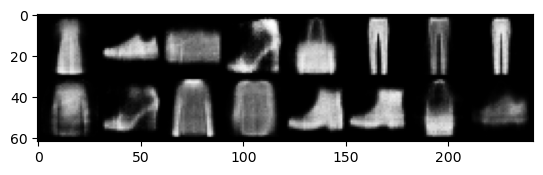

In [ ]:
# SOLUTION (cont)

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader_FMNIST, optimizer, criterion, reshape=True)
    test(model, test_loader_FMNIST, criterion, reshape=True) 

epoch : 1/10, Train loss = 0.056336
epoch : 1/10, Test loss = 0.032479


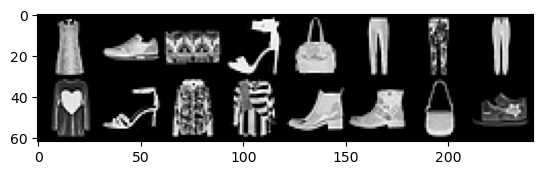

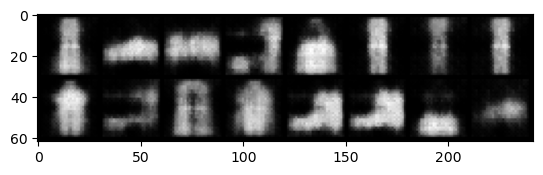

epoch : 2/10, Train loss = 0.030075
epoch : 2/10, Test loss = 0.028254


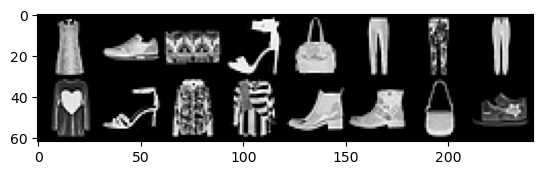

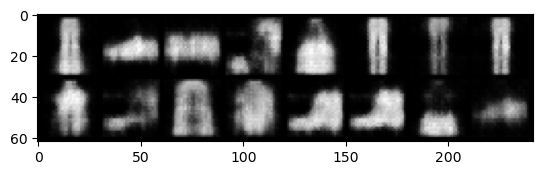

epoch : 3/10, Train loss = 0.027100
epoch : 3/10, Test loss = 0.026018


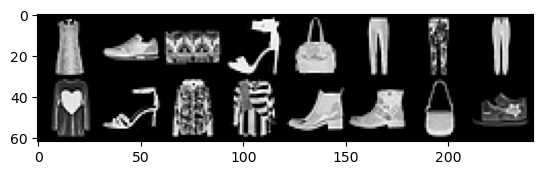

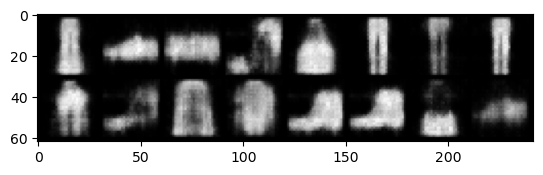

epoch : 4/10, Train loss = 0.025121
epoch : 4/10, Test loss = 0.024355


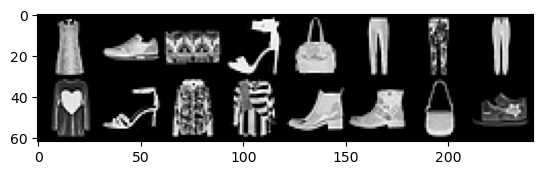

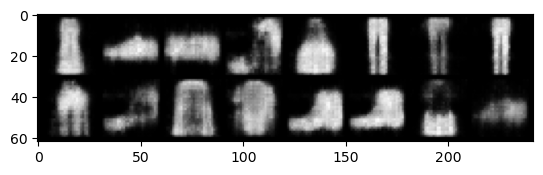

epoch : 5/10, Train loss = 0.023652
epoch : 5/10, Test loss = 0.023109


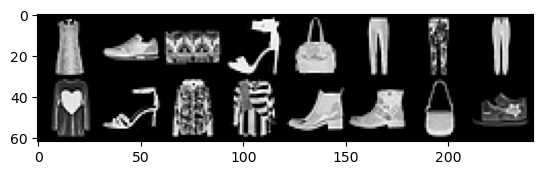

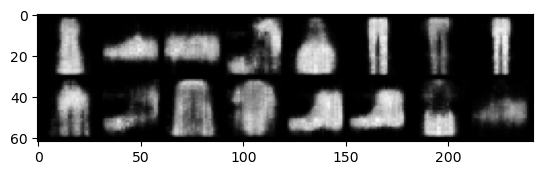

epoch : 6/10, Train loss = 0.022649
epoch : 6/10, Test loss = 0.022270


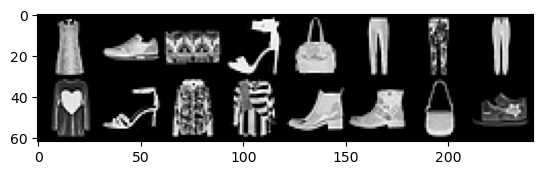

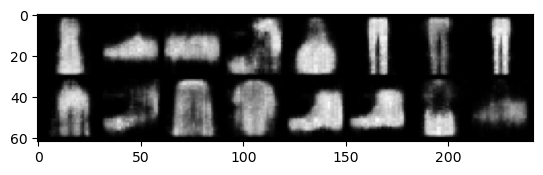

epoch : 7/10, Train loss = 0.021916
epoch : 7/10, Test loss = 0.021715


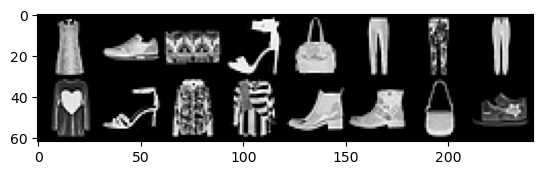

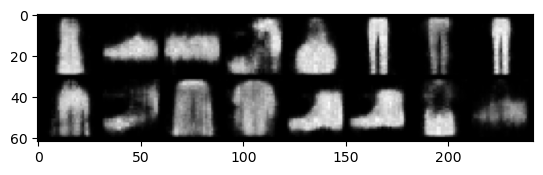

epoch : 8/10, Train loss = 0.021330
epoch : 8/10, Test loss = 0.021110


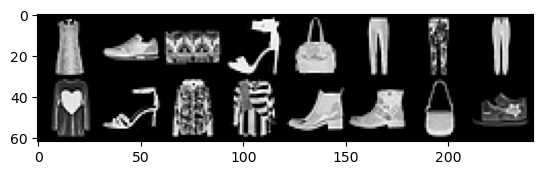

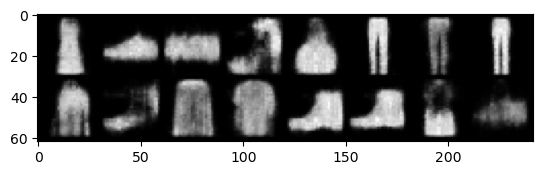

epoch : 9/10, Train loss = 0.020888
epoch : 9/10, Test loss = 0.020689


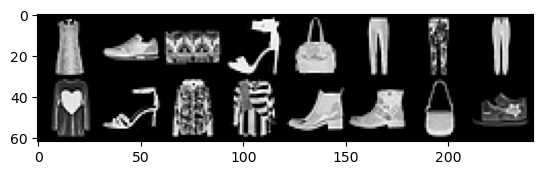

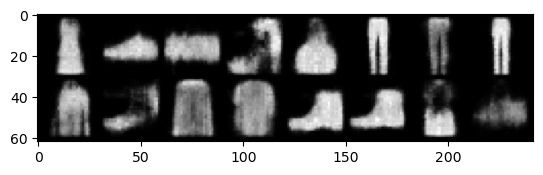

epoch : 10/10, Train loss = 0.020519
epoch : 10/10, Test loss = 0.020443


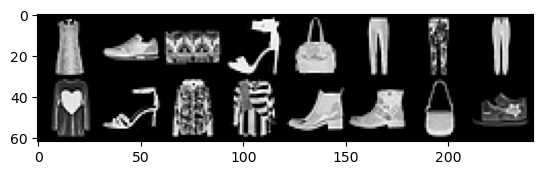

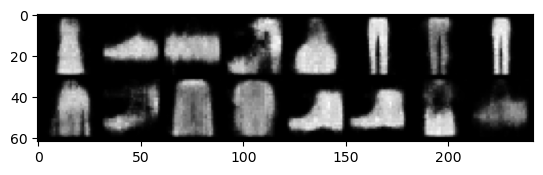

In [ ]:
# SOLUTION (Cont)

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader_FMNIST, optimizer, criterion)
    test(model, test_loader_FMNIST, criterion) 